# Анализ cамых прибыльных мобильных игр, которые принесли не менее 100 млн. долл. валового дохода

## Описание датасета


Это набор данных о мобильных видеоиграх, валовой доход которых составил не менее 100 млн. долл. Среди них более 30 мобильных игр, валовой доход которых превысил 1 млрд. долл. Наибольшее количество игр в списке принадлежит компании Tencent, которая издает и/или владеет 12 играми, входящими в список, в том числе тремя играми из первой десятки.

Структура <code>mobile-games.csv</code>:


<div>


* <code>Game</code> — название игры,

* <code>Revenue</code> — валовый доход,

* <code>Initial release</code> — дата первоначального выпуска,
    
* <code>Publisher(s)</code> — название издателя (издателей),
    
* <code>Genre(s)</code> — жанр(ы).
        
</div>

## Цель проекта

Провести анализ данных и ответить на следующие вопросы:
<div>

* Каков Топ 10 игр по прибыли?

* Как влияет на выручку год выпуска игры?

* Как влияют на доходы различные жанры (типы игр)?

* Как влияют на доходы разные издатели?

* В какое время года вышло больше всего игр?

</div>

### Обзор и предобработка данных

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from plotly import graph_objects as go
sns.set()

In [3]:
try:
  data = pd.read_csv('mobile-games.csv')
except:
  print('Что-то пошло не так')

In [4]:
# Функция для показа общей информации о датасете
def dataset_info(dataset):
    # Вывод первых 10 строк датасета
    print("Первые 10 строк датасета:")
    print(dataset.head(10))

    # Вывод типов данных и общей информации о датасете
    print("\nТипы данных и общая информация:")
    print(dataset.info())

    # Вывод статистической информации о датасете
    print("\nСтатистическая информация:")
    print(dataset.describe())

    # Подсчет количества пропусков в датасете
    count=0
    for element in dataset.columns:
        if dataset[element].isna().sum() > 0:
            print('\n', element, '-', dataset[element].isna().sum(), 'пропусков')
            count=+1
    if count ==0:
        print('\nПропусков нет')

    # Подсчет количества дубликатов в датасете
    num_duplicates = dataset.duplicated().sum()
    print("\nКоличество дубликатов в датасете:", num_duplicates)

In [5]:
dataset_info(data)

Первые 10 строк датасета:
                              Game      Revenue Initial release  \
0  Honor of Kings / Arena of Valor  14667500000      2015-11-26   
1                   Monster Strike  10000000000      2013-08-08   
2                      PUBG Mobile   9000000000      2018-03-19   
3                 Puzzle & Dragons   8578340000      2012-02-20   
4                   Clash of Clans   8000000000      2012-08-02   
5                       Pokémon Go   7760000000      2016-07-06   
6                 Candy Crush Saga   7456000000      2012-11-14   
7                 Fate/Grand Order   6300000000      2015-07-30   
8         Fantasy Westward Journey   4700000000      2015-03-26   
9                 Garena Free Fire   4330000000      2017-12-04   

                               Publisher(s)                 Genre(s)  
0                             Tencent Games                     MOBA  
1                                      Mixi  Puzzle / RPG / Strategy  
2       Tencent Games /

Для удобства внесем изменения в названии столбцов


In [6]:
data.columns = data.columns.str.lower()
data = data.rename(columns={"initial release": "initial_release", "genre(s)": "genre", "publisher(s)": "publishers"})
data.columns

Index(['game', 'revenue', 'initial_release', 'publishers', 'genre'], dtype='object')

В датасете 104 строки и 5 столбцов. Пропусков и дубликатов нет. Общая информация о данных получена, можно приступать к исследовательскому анализу

#### Каков Топ 10 игр по прибыли?

In [7]:
data.groupby('game').revenue.agg('sum').nlargest(10)

game
Honor of Kings / Arena of Valor    14667500000
Monster Strike                     10000000000
PUBG Mobile                         9000000000
Puzzle & Dragons                    8578340000
Clash of Clans                      8000000000
Pokémon Go                          7760000000
Candy Crush Saga                    7456000000
Fate/Grand Order                    6300000000
Fantasy Westward Journey            4700000000
Garena Free Fire                    4330000000
Name: revenue, dtype: int64

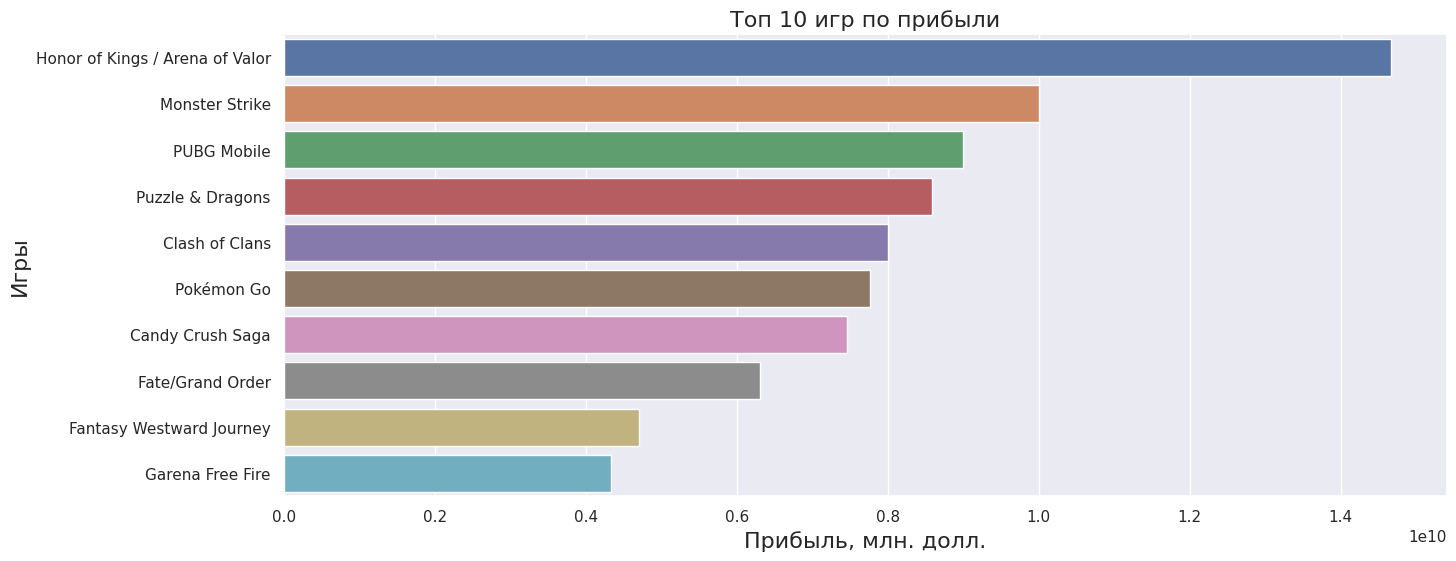

In [8]:
plt.figure(figsize=(15, 6))
games = data.sort_values(by='revenue',ascending=False)['game'].values[:10]
revenue = data.sort_values(by='revenue',ascending=False)['revenue'].values[:10]
ax = sns.barplot(x=revenue,
            y=games,
            )
ax.set_title('Топ 10 игр по прибыли', fontsize=16)
ax.set_ylabel('Игры', fontsize=16)
ax.set_xlabel('Прибыль, млн. долл.', fontsize=16)
plt.show()

#### Влияет ли на выручку год выпуска игры?

Добавим в датасет отдельно колонку с годом выпуска

In [9]:
data['year'] = pd.DatetimeIndex(data['initial_release']).year
data

,game,revenue,initial_release,publishers,genre,year
0,Honor of Kings / Arena of Valor,14667500000,2015-11-26,Tencent Games,MOBA,2015
1,Monster Strike,10000000000,2013-08-08,Mixi,Puzzle / RPG / Strategy,2013
2,PUBG Mobile,9000000000,2018-03-19,Tencent Games / Krafton / VNG Games,Battle royale,2018
3,Puzzle & Dragons,8578340000,2012-02-20,GungHo Online Entertainment,RPG / Puzzle,2012
4,Clash of Clans,8000000000,2012-08-02,Supercell (Tencent),Strategy,2012
...,...,...,...,...,...,...
99,Yahtzee With Buddies,113000000,2017-11-01,Scopely,Yahtzee,2017
100,Dragon Quest Tact,111990000,2020-07-16,Square Enix,Tactical RPG,2020
101,Fallout Shelter,100000000,2015-06-14,Bethesda Softworks,Simulation (CMS),2015
102,Mafia City,100000000,2017-07-25,Yotta Games,RPG,2017


In [10]:
#Сгруппируем данные по году и выручке
data_rev_year = data.groupby("year")["revenue"].mean().sort_values(ascending=False).reset_index()
data_rev_year

,year,revenue
0,2013,4.600000e+09
1,2012,3.914805e+09
2,2015,2.463640e+09
3,2016,1.508344e+09
4,2018,1.281467e+09
5,2017,1.218980e+09
6,2014,1.004133e+09
7,2019,8.845920e+08
8,2020,6.376988e+08
9,2021,5.503283e+08


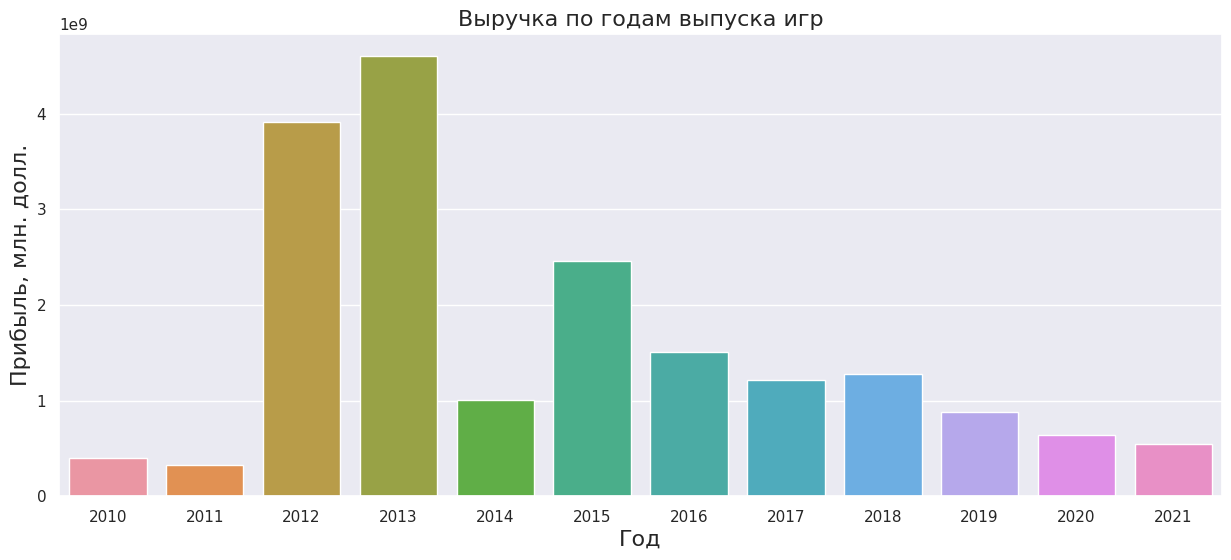

In [11]:
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='year',
            y='revenue',
            data=data_rev_year,
            errorbar=None
            )
ax.set_title('Выручка по годам выпуска игр', fontsize=16)
ax.set_ylabel('Прибыль, млн. долл.', fontsize=16)
ax.set_xlabel('Год', fontsize=16)
plt.show()

Интересная статистика. В 2012 и 2013 году выручка за игры была гораздо выше, чем в прочие годы

#### Как влияют на доходы различные жанры (типы игр)?

In [12]:
data_rev_genre = data.groupby("genre")["revenue"].mean().sort_values(ascending=False).reset_index()
data_rev_genre

,genre,revenue
0,Puzzle / RPG / Strategy,1.000000e+10
1,RPG / Puzzle,6.039170e+09
2,Augmented reality,4.343860e+09
3,Battle royale,4.003818e+09
4,GCS / MMO,3.919000e+09
5,MOBA,3.570700e+09
6,Casual / Casino,3.008000e+09
7,Real-time strategy,3.000000e+09
8,Puzzle / Decoration,1.837333e+09
9,Fighting,1.784000e+09


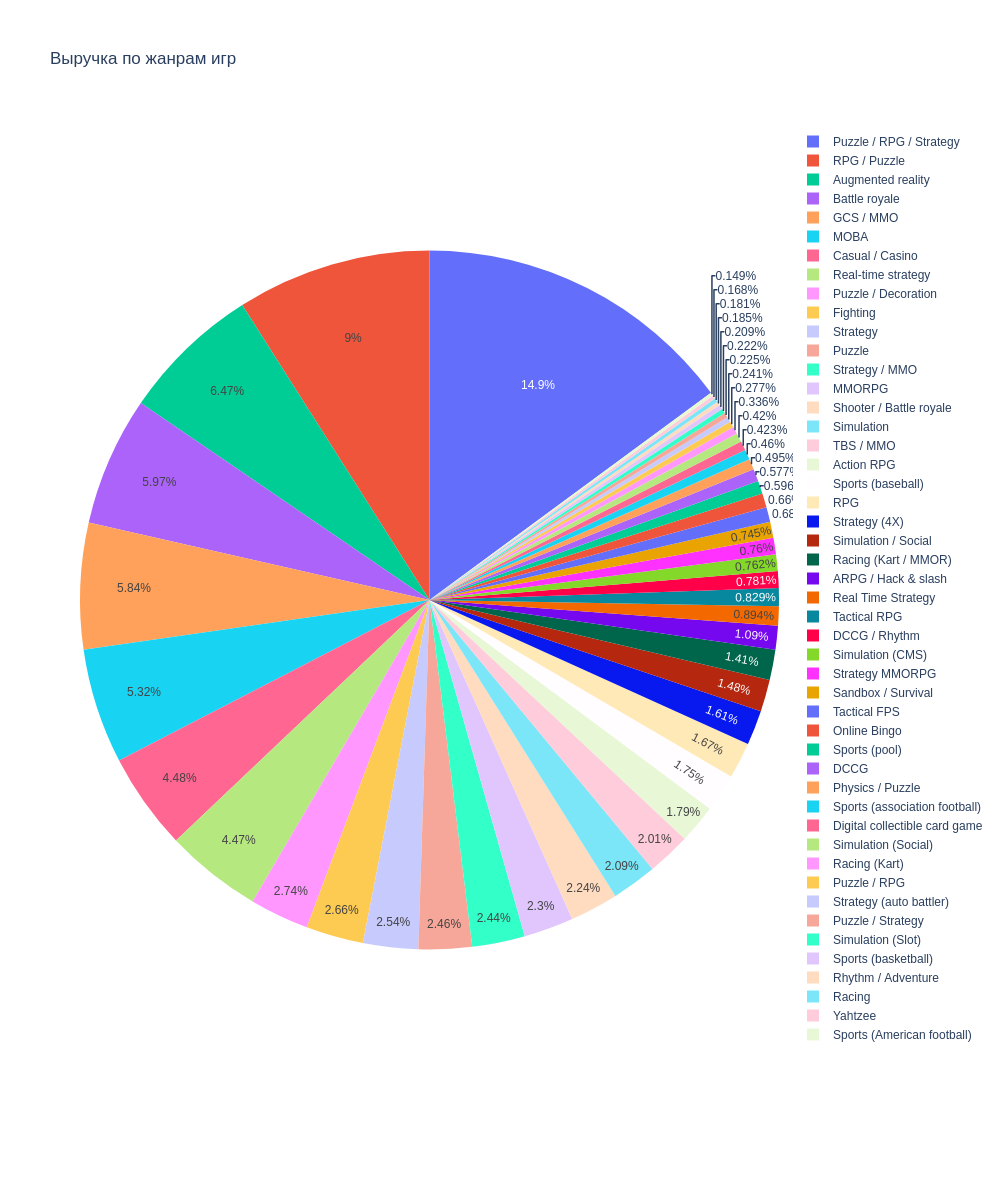

In [13]:
fig = px.pie(data_rev_genre, values='revenue', names='genre', title='Выручка по жанрам игр')
fig.update_layout(
    height=1200,  # Set the height in pixels
    width=1000    # Set the width in pixels
)
fig.show("png")

Самая прибыльная комбинация жанров - РПГ, Пазлы и Стратегии, около 10 миллиардов долларов составляет выручка игр с такими жанрами. Наименее прибыльные жанры - Спорт(американский футбол,), Ятзи(покер на костях) и Гонки, прибыль которых составляет около ста миллионов долларов

#### Как влияют на доходы разные издатели?

In [14]:
data_rev_publishers = data.groupby("publishers")["revenue"].mean().sort_values(ascending=False).reset_index()
data_rev_publishers

,publishers,revenue
0,Tencent Games,1.466750e+10
1,Mixi,1.000000e+10
2,Tencent Games / Krafton / VNG Games,9.000000e+09
3,GungHo Online Entertainment,8.578340e+09
4,Niantic / The Pokémon Company,7.760000e+09
...,...,...
66,Bandai Namco / Alibaba Group,1.170000e+08
67,CMGE,1.138400e+08
68,Scopely,1.130000e+08
69,Bethesda Softworks,1.000000e+08


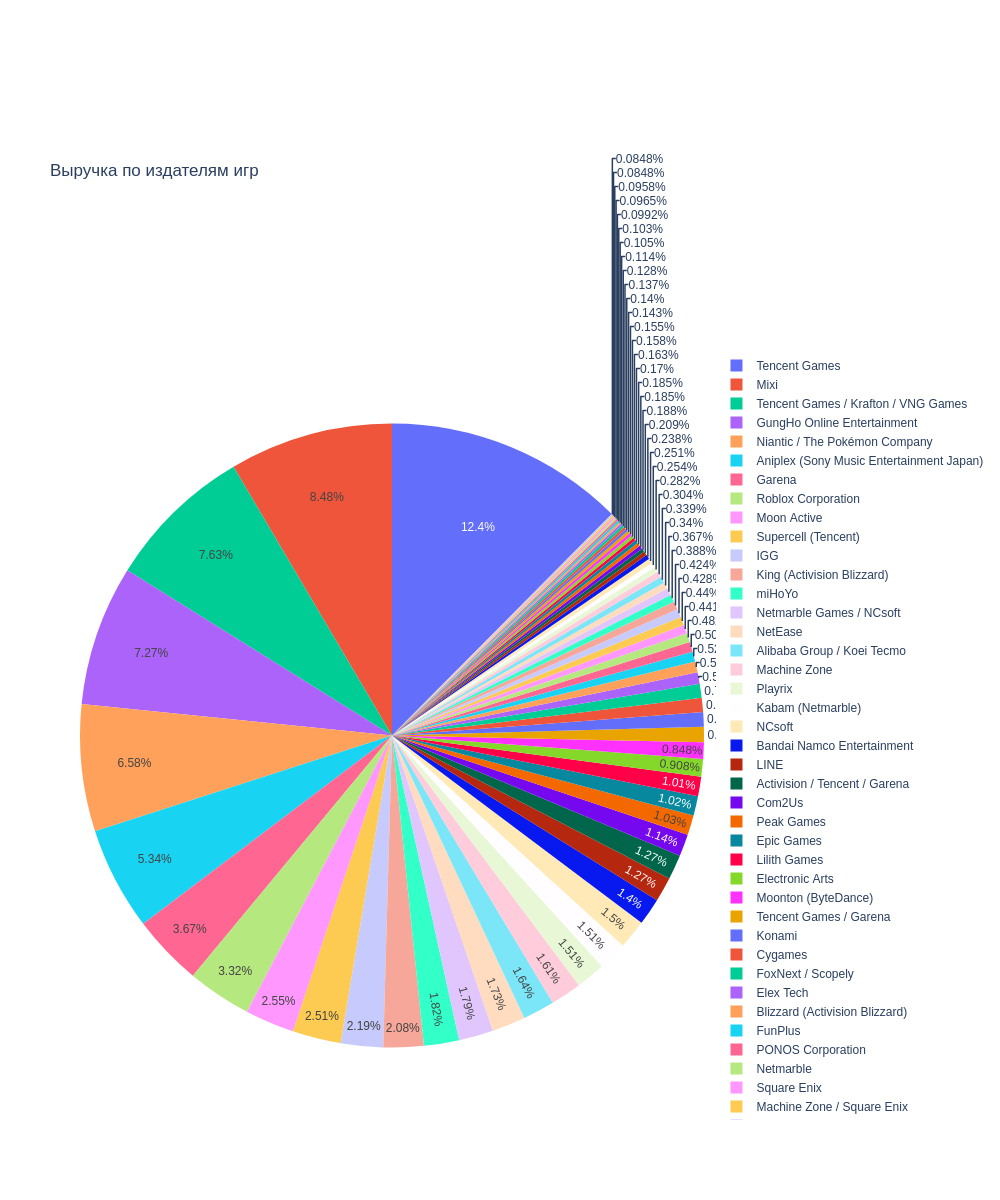

In [15]:
fig = px.pie(data_rev_publishers, values='revenue', names='publishers', title='Выручка по издателям игр')
fig.update_layout(
    height=1200,  # Set the height in pixels
    width=1000    # Set the width in pixels
)
fig.show("png")

Топ 3 самым прибыльных издателей - Tencent Games, Mixi и объединение Tencent Games / Krafton / VNG Games. Их выручка равна 14 667 500 000, 10 000 000 000 и 9 000 000 000 соответственно. Наименее прибвльными являются Yotta Games, Bethesda и Scopely с выручкой в 100 млн. долларов.

#### В какое время года вышло больше всего игр?

Чтобы ответить на этот вопрос, нужно добавить колонку с временами года в наш датасет

In [16]:
#Изменим тип данных
data['initial_release'] = pd.to_datetime(data['initial_release'])

In [17]:
# Определим функцию для отображения месяцев на времена года
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Весна'
    elif 6 <= month <= 8:
        return 'Лето'
    elif 9 <= month <= 11:
        return 'Осень'
    else:
        return 'Зима'

In [18]:
data['season'] = data['initial_release'].apply(get_season)

In [19]:
data

,game,revenue,initial_release,publishers,genre,year,season
0,Honor of Kings / Arena of Valor,14667500000,2015-11-26,Tencent Games,MOBA,2015,Осень
1,Monster Strike,10000000000,2013-08-08,Mixi,Puzzle / RPG / Strategy,2013,Лето
2,PUBG Mobile,9000000000,2018-03-19,Tencent Games / Krafton / VNG Games,Battle royale,2018,Весна
3,Puzzle & Dragons,8578340000,2012-02-20,GungHo Online Entertainment,RPG / Puzzle,2012,Зима
4,Clash of Clans,8000000000,2012-08-02,Supercell (Tencent),Strategy,2012,Лето
...,...,...,...,...,...,...,...
99,Yahtzee With Buddies,113000000,2017-11-01,Scopely,Yahtzee,2017,Осень
100,Dragon Quest Tact,111990000,2020-07-16,Square Enix,Tactical RPG,2020,Лето
101,Fallout Shelter,100000000,2015-06-14,Bethesda Softworks,Simulation (CMS),2015,Лето
102,Mafia City,100000000,2017-07-25,Yotta Games,RPG,2017,Лето


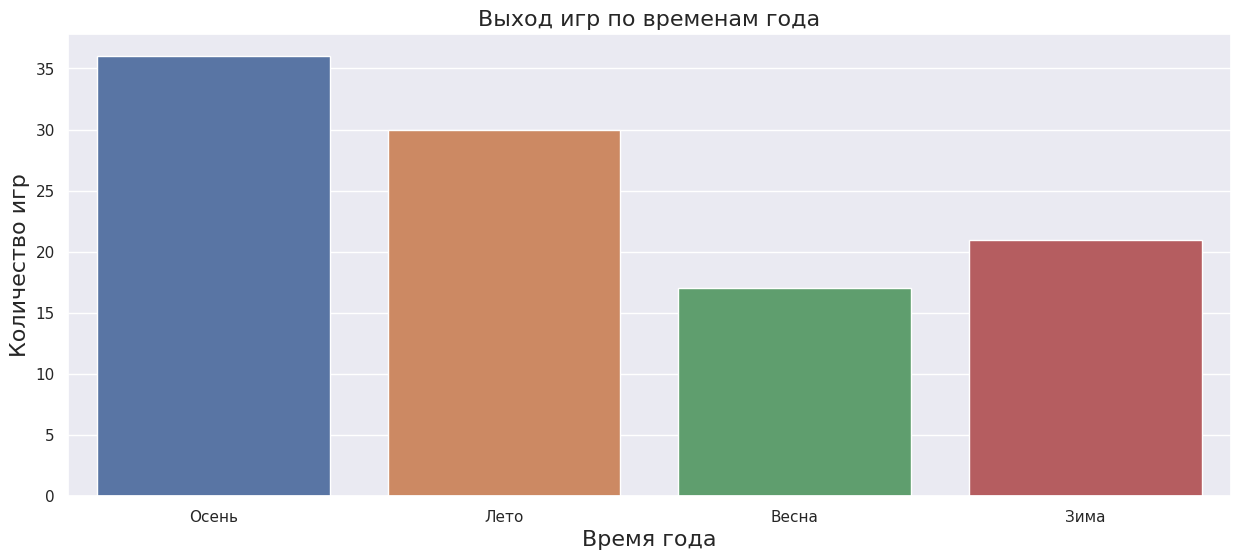

In [20]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(data, x="season")
ax.set_title('Выход игр по временам года', fontsize=16)
ax.set_ylabel('Количество игр', fontsize=16)
ax.set_xlabel('Время года', fontsize=16)
plt.show()

Больше всего игр приходится на осень

## Вывод

Был проведен анализ и предобработка данных, а так же даны ответы на поставленные вопросы исследования
<div>

* Каков Топ 10 игр по прибыли? <br>
Ответ: Honor of Kings / Arena of Valor; Monster Strike; PUBG Mobile; Puzzle & Dragons; Clash of Clans; Pokémon Go; Candy Crush Saga; Fate/Grand Order; Fantasy Westward Journey; Garena Free Fire.

* Как влияет на выручку год выпуска игры? <br>
Ответ: В 2012 и 2013 году выручка за игры была гораздо выше, чем в прочие годы. Выручку по все годам, представленным в датасете, можно посмотреть на графике.

* Как влияют на доходы различные жанры (типы игр)? <br>
Ответ: Самая прибыльная комбинация жанров - РПГ, Пазлы и Стратегии, около 10 миллиардов долларов составляет выручка игр с такими жанрами. Наименее прибыльные жанры - Спорт(американский футбол,), Ятзи(покер на костях) и Гонки, прибыль которых составляет около ста миллионов долларов

* Как влияют на доходы разные издатели?<br>
Ответ: Топ 3 самым прибыльных издателей - Tencent Games, Mixi и объединение Tencent Games / Krafton / VNG Games. Их выручка равна 14 667 500 000, 10 000 000 000 и 9 000 000 000 соответственно. Наименее прибвльными являются Yotta Games, Bethesda и Scopely с выручкой в 100 млн. долларов.

* В какое время года вышло больше всего игр?<br>
Ответ: Больше всего игр вышло осенью
</div>